In this file I start by implementing a compressed sensing reconstruction approach. I want to have a well accepted classical method 
as a baseline for my later deep learning models.

In [1]:
import sys
import os

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '2' #, this way I would choose GPU 3 to do the work

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
import time
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from scipy.fft import fft2, fftshift
from scipy.io import loadmat
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from scipy.io import savemat
import nibabel as nib
import h5py

import plotly.graph_objects as go

In [ ]:
# Vol = 7
# data = np.load(f'Vol{Vol}/OriginalData/data.npy')
# mask = np.load(f'Vol{Vol}/masks/brain_mask.npy')
# maskL = np.load(f'Vol{Vol}/masks/lipid_mask.npy')

# data = np.transpose(data, (1,2,0,3))
# mask = np.transpose(mask, (1,2,0))
# maskL = np.transpose(maskL, (1,2,0))

# print(data.shape)
# print(mask.shape)
# print(maskL.shape)

# np.save('data.npy', data)
# np.save('brain_mask.npy', mask)
# np.save('lipid_mask.npy', maskL)


(64, 64, 35, 840)
(64, 64, 35)
(64, 64, 35)


In [25]:
# import nibabel as nib

# mnc_img = nib.load('mask_lipid.mnc')   # load the MINC file
# Lipid_Mask    = mnc_img.get_fdata()          # NumPy array of your volume
# affine  = mnc_img.affine               # voxel-to-world transform (if you need it)

# print(Lipid_Mask.shape)


In [26]:
# Vol = 7
# # Load directly as complex from the HDF5 file
# with h5py.File(f'UnprocessedData/CombinedCSI_Vol{Vol}.mat', 'r') as f:
#     raw = f['csi']['Data'][:]
#     data = raw['real'] + 1j * raw['imag']
#     mask = f['mask'][:]

# #Lipid_Mask = np.swapaxes(nib.load(f'mask_lipid_Vol{Vol}.nii.gz').get_fdata(), -1, 0)    
# #Lipid_Mask = Lipid_Mask[:, ::-1, ::-1] # for some reason axis orientation is differnz for this nii.gz gile, this line fixes that
# spectrum = np.fft.fftshift(np.fft.fftn(data, axes=(0,)), axes=(0,))

In [ ]:
# Vol = 7
# np.save(f'data_vol{Vol}.npy', data)
# np.save(f'lipid_mask_vol{Vol}.npy', Lipid_Mask)
# np.save(f'brain_mask_vol{Vol}.npy', mask)

In [28]:
data.shape

(840, 35, 64, 64)

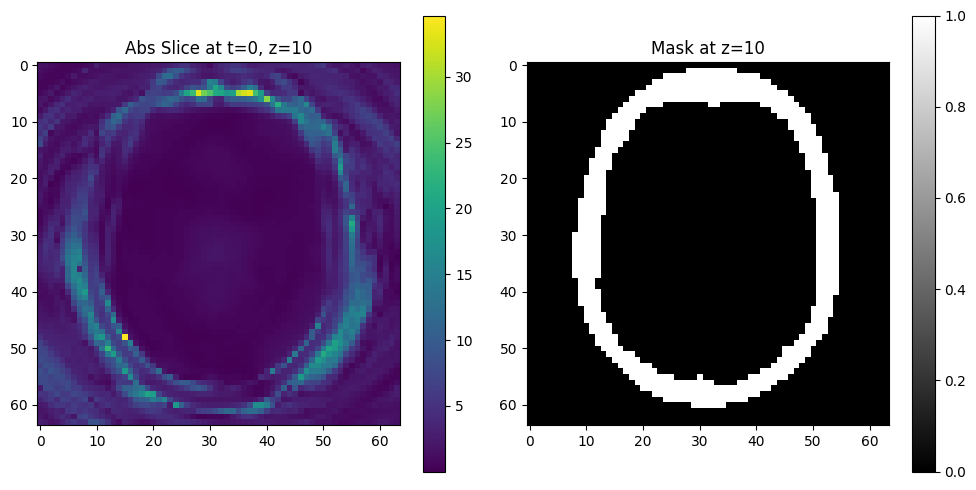

In [15]:
import matplotlib.pyplot as plt
import numpy as np

t, z = 0, 10
Slice = np.abs(data)[t, z, :, :]#mask[z, :, :]#np.abs(data)[t, z, :, :]
MASK = Lipid_Mask[z, :, :] #+ mask[z, :, :]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Show the Slice
im0 = axes[0].imshow(Slice, cmap='viridis')
axes[0].set_title(f"Abs Slice at t={t}, z={z}")
fig.colorbar(im0, ax=axes[0])

# Show the MASK
im1 = axes[1].imshow(MASK, cmap='gray')
axes[1].set_title(f"Mask at z={z}")
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()



0.0
1.0


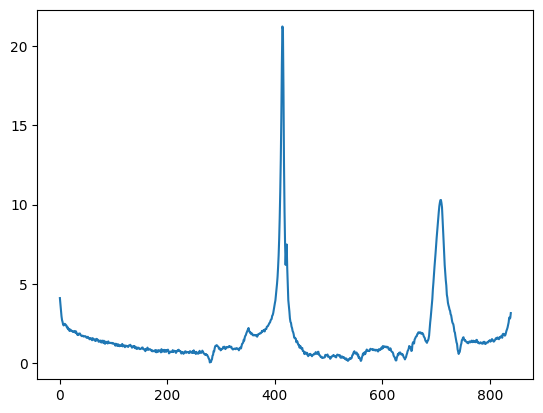

In [23]:
z, x, y = 10, 35, 14

print(Lipid_Mask[z,x,y])
print(mask[z,x,y])

Spectrum = spectrum[:,z,x,y]

plt.plot(np.abs(Spectrum))

In [4]:
#data_coils = loadmat('coil_uncombined_data_Fully_Sampled.mat') #FULLY SAMPLED!
#data_coils = data_coils['coil_uncombined_data']['Data'][0,0]
#sos_combined = np.sqrt(np.sum(np.abs(data_coils)**2, axis=4))
#sos_combined = sos_combined / np.max(np.abs(sos_combined))

#data_coils = data_coils['Data'][0,0]

In [5]:
#### take data from before coil combination and combine it yourself
data_2 = loadmat('MultiChannelTest/coil_uncombined_data_AF5.mat')
data_2 = data_2['coil_uncombined_data']['Data'][0,0]

data_2 = np.sqrt(np.sum(np.abs(data_2)**2, axis=4)) # sos coil combination
data_2 = data_2/np.max(np.abs(data_2))

## Compute MSE wrt ground truth after absolute value
mse = np.mean((np.abs(data_1) - np.abs(data_2)) ** 2)
print("MSE:", mse)


MSE: 9.98679081264217e-05


In [6]:
## Compute MSE wrt ground truth after absolute value
mse = np.mean((np.abs(data_3) - np.abs(data_2)) ** 2)
print("MSE:", mse)

MSE: 5.660854911821432e-05


In [7]:
#### Let the coil combination be done be the default algorithm

#data_3 = loadmat('MultiChannelTest/coil_combined_AF5.mat')
#data_3 = data_3['csi']
#data_3 = data_3['Data'][0,0]

#data_3 = data_3 / np.max(np.abs(data_3))

mse = np.mean((np.abs(data_1) - np.abs(data_3)) ** 2)
print("MSE:", mse)

MSE: 3.495364746370443e-05


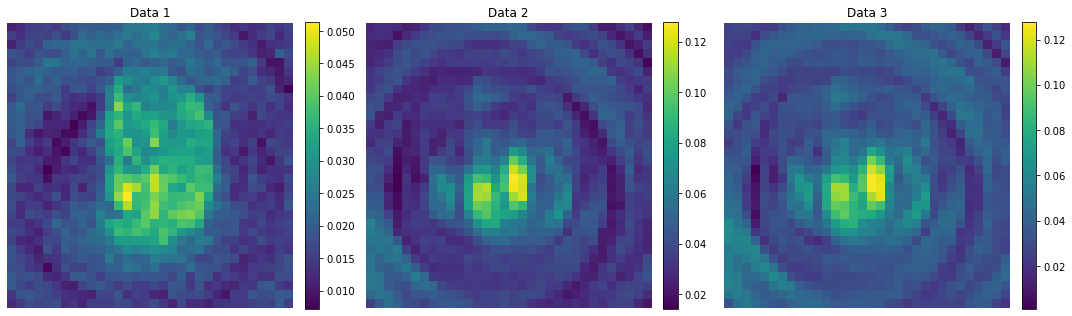

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Assume data_1, data_2, data_3 are your complex NumPy arrays of shape (x, y, z, t, T)
# Let's say you want to fix:
z_idx = 15
t_idx = 1
T_idx = 0

# Extract 2D slices at given z, t, T
slice_1 = np.abs(data_1[:, :, z_idx, t_idx, T_idx])
slice_2 = np.abs(data_2[:, :, z_idx, t_idx, T_idx])
slice_3 = np.abs(data_3[:, :, z_idx, t_idx, T_idx])

# Plot them side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

titles = ['Data 1', 'Data 2', 'Data 3']
slices = [slice_1, slice_2, slice_3]

for ax, slc, title in zip(axes, slices, titles):
    im = ax.imshow(slc, cmap='viridis')  # Or 'gray', 'plasma', etc.
    ax.set_title(title)
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [9]:
import numpy as np
import matplotlib.pyplot as plt

z, t, T = 15, 1, 0

Slice_1 = np.abs(data_1[:, :, z, t, T])
Slice_2 = np.abs(data_coils[:, :, z, t, 0,T])

# Compute relative difference (avoid division by zero)
epsilon = 1e-8
relative_diff = np.abs(Slice_1 - Slice_2) / (0.5*np.abs(Slice_1+Slice_2))

# Plot all three slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im0 = axes[0].imshow(Slice_1, cmap='viridis')
axes[0].set_title("Slice 1")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(Slice_2, cmap='viridis')
axes[1].set_title("Slice 2")
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(relative_diff, cmap='hot')
axes[2].set_title("Relative Difference")
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()


NameError: name 'data_coils' is not defined

In [ ]:
rel_diff = np.abs(data_1 - data_2) / (0.5*np.abs(data_2+data_1))

max_rel_diff = np.max(rel_diff)
print("Max relative difference:", max_rel_diff)

In [ ]:
FT = np.fft.fftshift(np.fft.fft(data_1, axis=-2), axes=-2)  

#data_2 = data_coils[...,0,:]

FT_2 = np.fft.fftshift(np.fft.fft(data_2, axis=-2), axes=-2)  

FT_3 = np.fft.fftshift(np.fft.fft(data_3, axis=-2), axes=-2)  



In [ ]:
x,y,z,T = 15,15,30,0

Slice_1 = np.abs(FT[x,y,z,:,0])
Slice_2 = np.abs(FT_3[x,y,z,:,0])
#Slice_3 = np.abs(FT[x,y,z,:,2])

plt.plot(Slice_1, label='fully sampled')
plt.plot(Slice_2, label='undersampled')
#plt.plot(Slice_3, label='T = 2')

plt.legend()
plt.xlabel('Time Index')
plt.ylabel('Amplitude')
plt.title('Slices at (x, y, z) = (15, 15, 25)')

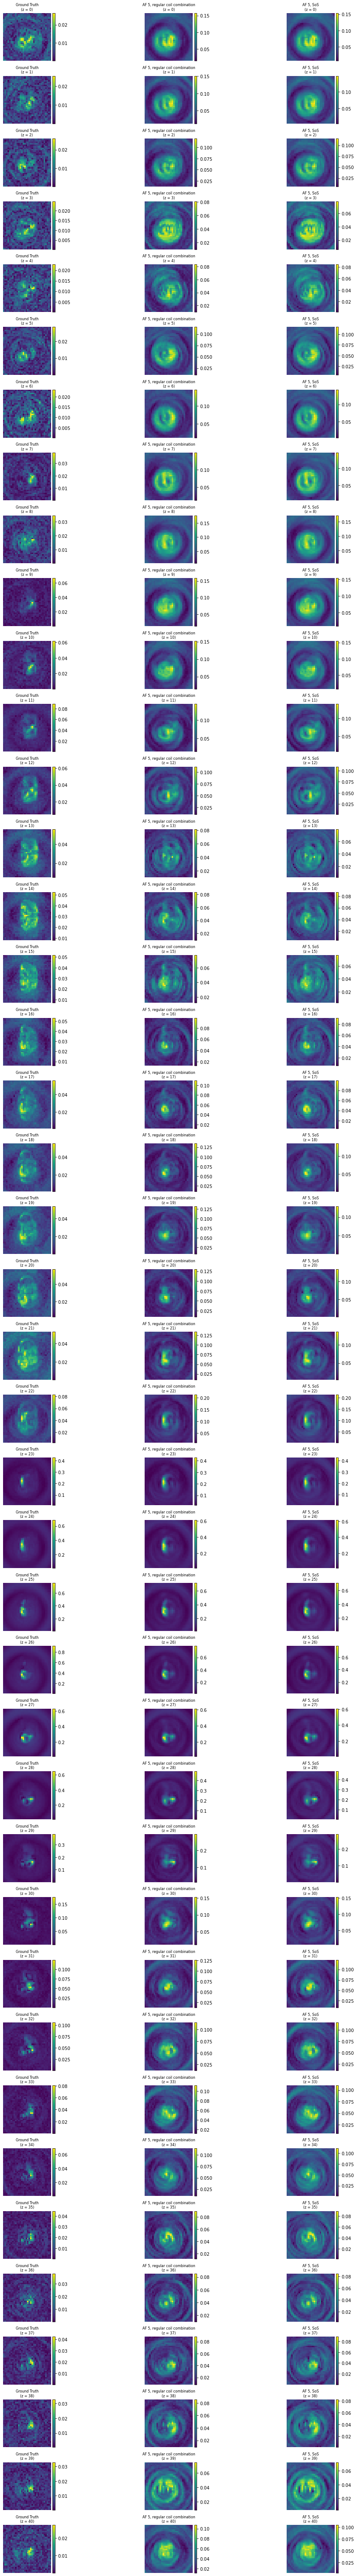

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming data_1, data_2, data_3 are already defined arrays
T = 2
t_idx = 1  # You can change this if needed
z_slices = 41  # Assuming z goes from 0 to 40

col_titles = ["Ground Truth", "AF 5, regular coil combination", "AF 5, SoS"]

fig, axes = plt.subplots(nrows=z_slices, ncols=3, figsize=(15, 2 * z_slices))

for z in range(z_slices):
    for col, (data, title) in enumerate(zip([data_1, data_2, data_3], col_titles)):
        ax = axes[z, col]
        im = ax.imshow(np.abs(data[:, :, z, t_idx, T]), cmap='viridis')
        ax.axis('off')
        ax.set_title(f"{title}\n(z = {z})", fontsize=8)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

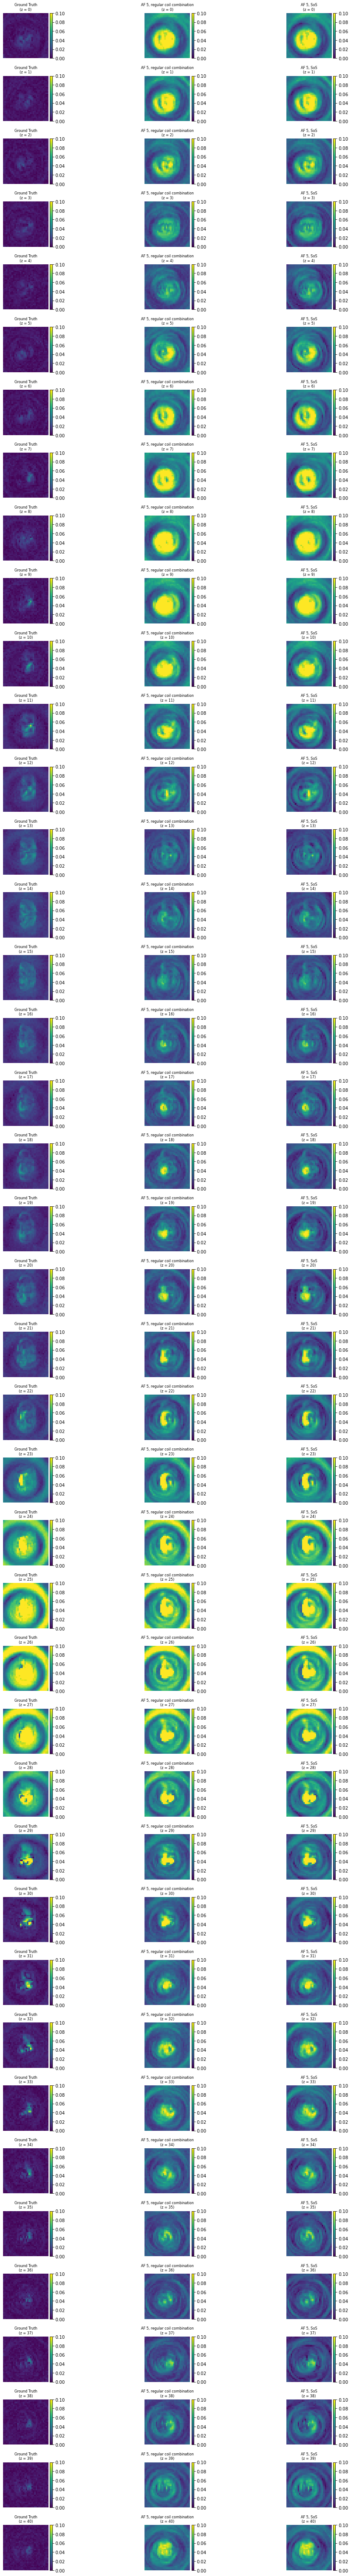

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming data_1, data_2, data_3 are already defined arrays
T = 2
t_idx = 1  # You can change this if needed
z_slices = 41  # Assuming z goes from 0 to 40

col_titles = ["Ground Truth", "AF 5, regular coil combination", "AF 5, SoS"]

fig, axes = plt.subplots(nrows=z_slices, ncols=3, figsize=(15, 2 * z_slices))

for z in range(z_slices):
    for col, (data, title) in enumerate(zip([data_1, data_2, data_3], col_titles)):
        ax = axes[z, col]
        # Fix the scale from 0 to 0.1 using vmin and vmax
        im = ax.imshow(np.abs(data[:, :, z, t_idx, T]), cmap='viridis', vmin=0, vmax=0.1)
        ax.axis('off')
        ax.set_title(f"{title}\n(z = {z})", fontsize=8)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

T = 2

# Use robust percentiles to set vmin and vmax
abs_data_1 = np.abs(data_1[:, :, :, 1, T])
vmin = np.percentile(abs_data_1, 1)
vmax = np.percentile(abs_data_1, 99)

fig, axes = plt.subplots(nrows=41, ncols=2, figsize=(10, 2 * 41))  # 2 columns

for z in range(41):
    # Left: data_1
    axes[z, 0].imshow(np.abs(data_1[:, :, z, 1, T]), vmin=vmin, vmax=vmax)
    axes[z, 0].axis('off')
    axes[z, 0].set_title(f'data_1 | z = {z}', fontsize=8)

    # Right: data_2 (same scale as data_1)
    axes[z, 1].imshow(np.abs(data_2[:, :, z, 1, T]), vmin=vmin, vmax=vmax)
    axes[z, 1].axis('off')
    axes[z, 1].set_title(f'data_2 | z = {z}', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# Spectral_Fit = np.zeros((22,22,21,162,8,6))

# for i in range(0,6):
#     Spectral_Fit[...,i] = np.load(f'fn_vb_DMI_CRT_P0{3+i}/Spectral_Fit.npy')
    
# Spectral_Fit = np.fft.ifft(np.fft.ifftshift(Spectral_Fit, axes=-3), axis=-3)
    
# for i in range(0,6):
#     Spectral_Fit[...,i] = Spectral_Fit[...,i]/np.max(np.abs(Spectral_Fit[...,i]))
    
# #Spectral_Fit = np.fft.fftshift(np.fft.fft(Spectral_Fit, axis=-3), axes=-3)

    
# np.save('Spectral_Fit.npy', Spectral_Fit)

In [ ]:
# Spectral_Fit = np.zeros((22,22,21,162,8,6))

# for i in range(0,6):
#      Spectral_Fit[...,i] = np.load(f'fn_vb_DMI_CRT_P0{3+i}/Spectral_Fit.npy')

In [ ]:
# # Spectra_Fit.shape == (22, 22, 21, 162, 8, 6)

# # Step 1: Get boolean masks
# # Step 1: Compute boolean mask over FID and time dimensions
# masks_bool = np.any(Spectral_Fit != 0, axis=(3, 4))  # shape: (22, 22, 21, 6)

# # Step 2: Convert to 0/1 integers
# masks = masks_bool.astype(np.uint8)  # shape: (22, 22, 21, 6)



In [ ]:
masks.shape

In [ ]:
#np.save('masks.npy', masks)


In [ ]:
masks.shape

plt.imshow(masks[:,:,10,0])

In [ ]:
masks_old.shape

In [ ]:

plt.imshow(masks_old[:,:,15,0])

In [ ]:
Spectral_Fit = np.load('Ground_Truth/Spectra_Fit_After_LR8/Spectral_Fit.npy')

Spectral_Fit = np.fft.fftshift(np.fft.fft(Spectral_Fit, axis=-3), axes=-3)

In [ ]:
x,y,z,T, D = 10,10,7,7,5
Line = np.real(Spectral_Fit[x,y,z,:,T, D])

plt.plot(Line)

In [ ]:
x,y,z,T, D = 14,10,7,7,1
Line = np.real(Spectral_Fit[x,y,z,:,T, D])

plt.plot(Line)

In [ ]:
nii_water = nib.load('SpecMap_LCMFit_1.nii.gz')
data_water = nii_water.get_fdata()

# Get the data as a NumPy array
nii_glc = nib.load('SpecMap_Glc.nii.gz')
data_glc = nii_glc.get_fdata()

nii_glx = nib.load('SpecMap_Glx.nii.gz')
data_glx = nii_glx.get_fdata()

nii_lac = nib.load('SpecMap_Lac.nii.gz')
data_lac = nii_lac.get_fdata()

data_summed = data_water+data_glc+data_glx+data_lac

data_all = nib.load('SpecMap_LCMFit.nii.gz').get_fdata()

data_in = nib.load('SpecMap_LCMInput.nii.gz').get_fdata()

In [ ]:
import matplotlib.pyplot as plt

x, y, z = 10, 10, 10

plt.plot(data_summed[x, y, z, :], label='Summed')
plt.plot(data_in[x, y, z, :], '--', label='Input (dashed)')

plt.legend()
plt.xlabel('Spectral Point')
plt.ylabel('Signal')
plt.title(f'Voxel ({x},{y},{z})')
plt.show()


In [ ]:
res = data_summed - data_summed

In [ ]:
np.max(np.abs(res))

In [ ]:
data_1 = loadmat('CombinedCSI_22_better.mat')
data_1 = data_1['csi']
data_1 = data_1['Data'][0,0]

data_2 = loadmat('CombinedCSI_22_tuneup.mat')
data_2 = data_2['csi']
data_2 = data_2['Data'][0,0]

data_3 = loadmat('CombinedCSI_22_upper_tuneup.mat')
data_3 = data_3['csi']
data_3 = data_3['Data'][0,0]

data_4 = loadmat('CombinedCSI_32_better.mat')
data_4 = data_4['csi']
data_4 = data_4['Data'][0,0]

In [ ]:
data_4.shapew
#data_FT = np.fft.fftshift(np.fft.fft(data, axis=-1), axes=-1)

In [ ]:


x,y,z = 20, 20 ,15

Slice = np.abs(data_1[x,y,z,:])

plt.plot(Slice)

In [ ]:
z, t = 15, 5

Slice = np.abs(data_1[:,:,z,t])

plt.imshow(Slice, origin='lower', cmap='viridis')  # or another colormap if you prefer
plt.title(f'Slice at z={z}, t={t}')
plt.xlabel('x-axis (voxel)')
plt.ylabel('y-axis (voxel)')
plt.colorbar(label='Signal Intensity')
plt.show()

In [ ]:
Data = np.load('Ground_Truth/Full_Rank/Full_Rank_All.npy')

Data_2 = Data.copy()

for i in range(0,5):

    Data_2[...,i] = low_rank(Data_2[...,i], 8)
    Data_2[...,i] = Data_2[...,i] / np.max(np.abs(Data_2[...,i]))
    savemat(f'P0{3+i}.mat', {'Data': Data_2[...,i]})
#



In [ ]:
P08[0,0,0,0,0]

In [ ]:
P03_LR = low_rank(P03,8)

In [ ]:
Data = np.fft.fftshift(np.fft.fft(Data, axis=-3), axes=-3)


In [ ]:
x,y,z,T, D = 9,9,9,0, 5

line = np.abs(Data[x,y,z,:,T, D])

plt.plot(line)

In [ ]:
line[50]

In [ ]:
SNR = np.load('SNR.npy')

In [ ]:
SNR.shape

In [ ]:
data = SNR

# Choose a z-index to slice at (it should be between 0 and 20)
z_index = 10  # for example, you can change this value

# Compute the global min and max for the chosen z-index over all 8 images
global_min = np.min(data[:, :, z_index, :])
global_max = np.max(data[:, :, z_index, :])

# Create a figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

# Loop over the 8 channels (last dimension)
for i in range(8):
    # Get the subplot axis. Here, i // 4 gives the row, and i % 4 gives the column.
    ax = axes[i // 4, i % 4]
    
    # Extract the slice for the given z_index and channel i
    img = data[:, :, z_index, i]
    
    # Plot the image using imshow with the same color scale for all plots
    im = ax.imshow(img, vmin=global_min, vmax=global_max, cmap='viridis')
    ax.set_title(f'Channel {i+1}')
    ax.axis('off')

# Adjust layout and add a single colorbar for all subplots
fig.subplots_adjust(right=0.85, wspace=0.3, hspace=0.3)
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [ ]:
SNR[:,10,10,0]

In [ ]:
US = np.load('Undersampled_Data/Possoin_Real/AF_5/Complementary_Masks/data.npy')

In [ ]:
GT = np.load('Ground_Truth/Full_Rank/Full_Rank_All.npy')

In [ ]:
mat_data_8 = loadmat('Undersampling_Skripts/Undersampling_Possoin/Undersampled_P03_AF5.mat')

csi_8 = mat_data_8['csi']

US_2 = csi_8['Data'][0,0]

In [ ]:
z, t, T = 10, 1, 7

Slice = np.abs(US_2)[:,:,z,t,T]

plt.imshow(Slice)

print(Slice[15,15])

In [ ]:
US = np.load('Undersampled_Data/Possoin_Real/AF_5/Complementary_Masks/data.npy')


In [ ]:
z, t, T = 10, 1, 7

Slice = np.abs(US)[:,:,z,t,T,0]

plt.imshow(Slice)

print(Slice[15,15])

In [ ]:
low_rank_input = US.copy()

for i in range(0,6):
    low_rank_input[...,i] = low_rank(US[...,i],8)

In [ ]:
Data = np.load('Ground_Truth/Full_Rank/Full_Rank_All.npy')

low_rank_GT = Data.copy()

for i in range(0,6):
    low_rank_GT[...,i] = low_rank(Data[...,i],8)

In [ ]:
np.save('GT_Low_Rank_Summit.npy',low_rank_GT)

In [ ]:
low_rank_GT.shape

In [ ]:


z, t, T = 10, 1, 0

Slice = np.abs(low_rank_input)[:,:,z,t,T,0]

plt.imshow(Slice)

print(Slice[15,15])

In [ ]:
x,y,z, T = 10, 10, 10, 7

ft_shifted_LR = np.fft.fftshift(np.fft.fft(low_rank_input, axis=-3), axes=-3)

plt.plot(np.abs(ft_shifted_LR)[x,y,z,:,T,0])

print(Slice[15,15])

In [ ]:
x,y,z, T = 10, 10, 10, 7

ft_shifted = np.fft.fftshift(np.fft.fft(low_rank_GT, axis=-3), axes=-3)

plt.plot(np.abs(ft_shifted)[x,y,z,:,T,0])

In [ ]:
US = np.load('Undersampled_Data/Possoin_Real/AF_5/Complementary_Masks/data.npy')
US_Reg = np.load('Undersampled_Data/Regular_Real/AF_4/Complementary_Masks/data.npy')
Data = np.load('Ground_Truth/Full_Rank/Full_Rank_All.npy')

In [ ]:
for i in range(0,6):
    print(np.max(np.abs(US[...,i]))/np.max(np.abs(Data[...,i])))

In [ ]:
for i in range(0,6):
    print(np.max(np.abs(US_Reg[...,i]))/np.max(np.abs(Data[...,i])))

In [ ]:
x,y,z,t, T = 10,10,10,5,5

Slice_C = np.abs(US_2[:,:,z,t,T]+US[:,:,z,t,T,0])

plt.imshow(Slice_C, cmap='viridis')  # You can change the colormap if needed
plt.colorbar(label="Intensity")  # Adds a scale bar
plt.title("Slice C")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [ ]:
Data = np.load('Ground_Truth/Full_Rank/Full_Rank_All.npy')

In [ ]:
x,y,z,t, T = 10,10,10,5,5

Slice = np.abs(Data[:,:,z,t,T,0])

plt.imshow(Slice, cmap='viridis')  # You can change the colormap if needed
plt.colorbar(label="Intensity")  # Adds a scale bar
plt.title("Slice C")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [ ]:
mat_data_8 = loadmat('fn_vb_DMI_CRT_P04/CombinedCSI_full_rank.mat')

csi_8 = mat_data_8['csi']

Data = csi_8['Data'][0,0]

DataSpec = np.fft.fftshift(np.fft.fft(Data, axis=-2), axes=-2)    

In [ ]:
FT = fourier_transform(Data)

In [ ]:
# Example: if you intend to take the slice at k_z = 0, set z to 0.
z, t, T = 0, 10, 7  # Adjust z if needed
Slice = np.abs(FT)[:, :, z, t, T]

plt.figure(figsize=(8,6))
im = plt.imshow(Slice, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar(im)
plt.xlabel('k_y')
plt.ylabel('k_x')
plt.title('|Singal| for k_z = 0')
plt.show()

In [ ]:
z, t, T = 10, 1, 7

Slice = np.abs(Data)[:,:,z,t,T]

plt.imshow(Slice)
plt.colorbar(label='Intensity')

In [ ]:
x,y,z,T = 10,15,10,7

plt.plot(np.abs(DataSpec[x,y,z,:,T]))

In [ ]:
print(np.max(np.abs(Data)))
print(np.mean(np.abs(Data)))

In [ ]:
DataUS = np.load('Undersampled_Data/Possoin_Real/AF_3/Complementary_Masks/data.npy')

In [ ]:
#DataUS = np.load('Undersampled_Data/Regular_Real/AF_4/Complementary_Masks/data.npy')

In [ ]:
print(np.max(np.abs(DataUS[...,1])))
print(np.mean(np.abs(DataUS[...,1])))

In [ ]:
z, t, T = 10, 1, 7

Slice = np.abs(DataUS)[:,:,z,t,T,0]

plt.imshow(Slice)
plt.colorbar(label='Intensity')

In [ ]:
mat_data_8 = loadmat('fn_vb_DMI_CRT_P04/CombinedCSI_full_rank.mat')

csi_8 = mat_data_8['csi']

Data = csi_8['Data'][0,0]

DataSpec = np.fft.fftshift(np.fft.fft(Data, axis=-1), axes=-1)    

In [ ]:
z, t, T = 10, 2, 0

Slice = np.abs(Data)[:,:,z,t,T]

plt.imshow(Slice)
plt.colorbar(label='Intensity')

In [ ]:
mat_data_8 = loadmat('MultiChannel/CombinedCSI.mat')

csi_8 = mat_data_8['csi']

Data = csi_8['Data'][0,0]

DataSpec = np.fft.fftshift(np.fft.fft(Data, axis=-1), axes=-1)    


In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(np.abs(DataSpec[15,15,15,:]), marker='o', linestyle='-', color='b', markersize=4, label="Data")

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [ ]:
z, t = 15, 20

Slice = np.abs(Data[:,:,z,t])

plt.imshow(Slice)

In [ ]:
def fft_and_shift(arr, axis=-1):
    """
    Computes the FFT along a chosen axis and shifts the zero-frequency component to the center.

    Parameters:
    - arr (ndarray): Input data.
    - axis (int): Axis along which to compute the FFT.

    Returns:
    - ndarray: Shifted FFT result.
    """
    fft_result = np.fft.fft(arr, axis=axis)  # Compute FFT along the specified axis
    fft_shifted = np.fft.fftshift(fft_result, axes=axis)  # Shift zero frequency to the center
    return fft_shifted

In [ ]:
mat_data_8 = loadmat('fn_vb_DMI_CRT_P03/CombinedCSI_full_rank.mat')

csi_8 = mat_data_8['csi']

Data_8 = csi_8['Data'][0,0]

FT = fourier_transform(Data_8)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

z, t, T = 10, 2, 7
SLICE = np.log(np.abs(FT[:,:,z,t,T]))

plt.imshow(SLICE, vmin=14, vmax=18)
plt.colorbar()  # This adds the scale (colorbar) to the plot
plt.show()


In [ ]:
SLICE[0,15]

In [ ]:
t, T = 0, 1

data_extracted = np.abs(FT[10,10,:, t, T])
plt.plot(data_extracted, marker='o', linestyle='-')
plt.xlabel('Index')
plt.ylabel('Magnitude')
plt.title('Abs from csikspace.Data[0]')
plt.grid(True)
plt.show()


In [ ]:
Data_8.shape

In [ ]:
def low_rank(data, rank):
    """
    Computes low rank decomposition of a matrix of shape 22*22*21*96*8
    
    Args: data (np.ndarray): numpy array of shape 22x22x21x96x8 for which the low
          rank decomposition should be computed.
          rank: The final rank.
          
    Returns: np.ndarray of rank 'rank' """
    
    (x, y, z, t, T) = data.shape

    # Reshape the tensor into a 2D matrix of shape (x*y*z, t*T)
    reshaped_matrix = data.reshape(x * y * z, T*t)

    # Perform Singular Value Decomposition
    U, singular_values, Vh = np.linalg.svd(reshaped_matrix, full_matrices=False)

    # Retain only the first 120 singular values
    k = rank*8
    singular_values_truncated = np.zeros_like(singular_values)
    singular_values_truncated[:k] = singular_values[:k]

    # Reconstruct the matrix using the truncated singular values
    S_truncated = np.diag(singular_values_truncated)  # Create the diagonal matrix
    reconstructed_matrix = np.dot(U, np.dot(S_truncated, Vh))

    # If needed, reshape back to the original 5D tensor shape
    reconstructed_tensor = reconstructed_matrix.reshape(x * y * z , T*t)

    data = reconstructed_tensor.reshape(x, y, z, t, T)
    
    return data

In [ ]:
FID = np.abs(Data_8[10,11,10,:,0])

plt.plot(FID)

In [ ]:
(x, y, z, t, T) = Data_8.shape

# Reshape the tensor into a 2D matrix of shape (x*y*z, t*T)
reshaped_matrix = Data_8.reshape(x * y * z, t*T)

# Perform Singular Value Decomposition
U, singular_values, Vh = np.linalg.svd(reshaped_matrix, full_matrices=False)

In [ ]:
AF = 5

US = np.load(f'Undersampled_Data/Possoin_Real/AF_{AF}/Complementary_Masks/data.npy')
GT = np.load('Ground_Truth/Full_Rank/Full_Rank_All.npy')

In [ ]:
z, t, T = 11, 1, 7

Slice = np.abs(US[:,:,z,t,T,0])

plt.figure(figsize=(6,6))
plt.imshow(np.abs(Slice), cmap='viridis', aspect='auto')  # Choose a colormap
plt.colorbar(label="Intensity")  # Add color bar
plt.title(f"Slice ")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

print(np.sum(np.abs(Slice)**2)/10**12)

In [ ]:
Slice = np.abs(GT[:,:,z,t,T,0])

plt.figure(figsize=(6,6))
plt.imshow(np.abs(Slice), cmap='viridis', aspect='auto')  # Choose a colormap
plt.colorbar(label="Intensity")  # Add color bar
plt.title(f"Slice ")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

print(np.sum(np.abs(Slice)**2)/10**12)

In [ ]:
# Slice = Data_8[:,:,10,1,7]

# plt.figure(figsize=(6,6))
# plt.imshow(np.abs(Slice), cmap='viridis', aspect='auto')  # Choose a colormap
# plt.colorbar(label="Intensity")  # Add color bar
# plt.title(f"Slice ")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.show()

# print(np.sum(np.abs(Slice)**2)/10**12)

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(np.abs(reconstructed_data_1), cmap='viridis', aspect='auto')  # Choose a colormap
plt.colorbar(label="Intensity")  # Add color bar
plt.title(f"Slice ")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

print(np.sum(np.abs(reconstructed_data_1)**2)/10**12)

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(np.abs(reconstructed_data), cmap='viridis', aspect='auto')  # Choose a colormap
plt.colorbar(label="Intensity")  # Add color bar
plt.title(f"Slice ")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

print(np.sum(np.abs(reconstructed_data)**2)/10**12)

In [ ]:

# Compute FFT
fft_data = np.fft.fft2(Slice)

# Shift the zero-frequency component to the center
fft_shifted = np.fft.fftshift(fft_data)

plt.imshow(np.log10(np.abs(fft_shifted)))

In [ ]:
for i in range(22):
    fft_shifted[i, (i+1) % 2::2] = 0
    
plt.imshow(np.log10(np.abs(fft_shifted)))

print(np.sum(np.abs(fft_shifted)**2)/10**12)

In [ ]:
ifft_shifted = np.fft.ifftshift(fft_shifted)  # Undo shift
reconstructed_data_2 = np.fft.ifft2(ifft_shifted)

1. Loading data

In [ ]:
mat_data_8 = loadmat('fn_vb_DMI_CRT_P08/CombinedCSI_full_rank.mat')

csi_8 = mat_data_8['csi']

Data_8 = csi_8['Data'][0,0]

#########

# mat_data_8_self = loadmat('P08.mat')

# csi_8_self = mat_data_8_self['csi']

# Data_8_self = csi_8_self['Data'][0,0]

In [ ]:
z, t, T = 10, 1, 7

SLICE = np.abs(Data_8_self)[:,:,z,t,T]

plt.imshow(SLICE)

In [ ]:
z, t, T = 10, 1, 7

SLICE = np.abs(Data_8)[:,:,z,t,T]

plt.imshow(SLICE)

In [ ]:
Data.shape
FT = fourier_transform(Data)

In [ ]:
z, t, T = 10, 1, 7

SLICE = np.abs(Data[:,:,z,t,T,0])

plt.figure(figsize=(6,6))
plt.imshow(SLICE, cmap='viridis', aspect='auto')  # Choose a colormap
plt.colorbar(label="Intensity")  # Add color bar
plt.title(f"Slice at z={z}, t={t}, T={T}")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [ ]:
zerofill = 96

Data_2_filled = np.pad(Data_2, ((0, 0), (0, 0), (0, 0), (0, zerofill), (0, 0)))
Data_filled = np.pad(Data[...,0], ((0, 0), (0, 0), (0, 0), (0, zerofill), (0, 0)))

Data2_spectral = np.fft.fftshift(np.fft.fft(Data_2_filled, axis=-2), axes=-2)
Data_spectral = np.fft.fftshift(np.fft.fft(Data_filled, axis=-2), axes=-2)



# Fixed indices for x, y, and T:
# ----------------------------------------------------------------------
# Fixed indices for x, y, and T
# ----------------------------------------------------------------------
x_fixed = 5
y_fixed = 10
T_fixed = 7

num_z = 21  # Number of z slices

# ----------------------------------------------------------------------
# Create a figure with 2 columns:
#   Column 1 -> Absolute value plots
#   Column 2 -> Residuals (GT - [Others])
# ----------------------------------------------------------------------
fig, axes = plt.subplots(nrows=num_z, ncols=2, figsize=(16, num_z * 3.5), sharex=True)

# If there's only one row, ensure axes is 2D
if num_z == 1:
    axes = np.array([axes])

for z in range(num_z):
    # Extract the spectra at [x_fixed, y_fixed, z, :, T_fixed]
    gt_spec  = Data2_spectral[x_fixed, y_fixed, z, :, T_fixed]
    mp_spec  = Data_spectral[x_fixed, y_fixed, z, :, T_fixed]
    
    # ------------------------------------------------------------------
    # Column 1: Plot absolute spectra
    # ------------------------------------------------------------------
    ax_abs = axes[z, 0]
    ax_abs.plot(np.abs(gt_spec),  label='LR8 Fabian',    color='blue')
    ax_abs.plot(np.abs(mp_spec),  label='LR8 My Code',color='orange')
    ax_abs.set_ylim(-50000, 350000)
    # Row label on the Y-axis
    ax_abs.set_ylabel(f'z = {z}')
    
    if z == 0:
        ax_abs.set_title('Absolute Value')
    ax_abs.legend(loc='upper left')
    
    # ------------------------------------------------------------------
    # Column 2: Plot residuals (Ground Truth - [Others])
    # ------------------------------------------------------------------
    ax_res = axes[z, 1]
    
    residual_gt_mp  = np.abs(gt_spec) - np.abs(mp_spec)
    
    ax_res.plot(residual_gt_mp,  label='GroundTruth - Model',        color='orange')

    if z == 0:
        ax_res.set_title('Residual')
    ax_res.legend(loc='upper left')
    ax_res.set_ylim(-50000, 350000)
plt.tight_layout()
plt.show()

In [ ]:
z, t, T = 12, 2, 0

images = np.abs(Data[:,:,z,t,T,:])
# Set up a 2-row, 3-column gri

# Set up a 2-row, 3-column grid
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

# Get min and max values across all images for a consistent color scale
vmin, vmax = images.min(), images.max()

# Create a colormap (not grayscale)
cmap = "viridis"  # You can also try 'plasma', 'inferno', or other colormaps

# Loop through all 6 images and display them
for i in range(6):
    row = i // 3  # Row index
    col = i % 3   # Column index
    im = axes[row, col].imshow(images[:, :, i], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[row, col].axis('off')
    axes[row, col].set_title(f"Image {i+1}")

# Create a shared colorbar
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust position
fig.colorbar(im, cax=cbar_ax)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Make space for colorbar
plt.show()


In [ ]:
Compare.shape

In [ ]:
Data.shape
#Data = Data[:,:,:,:30,:,:]

Low_Rank_8_0 = low_rank(Data[...,0], 8)
Low_Rank_8_1 = low_rank(Data[...,1], 8)
Low_Rank_8_2 = low_rank(Data[...,2], 8)
Low_Rank_8_3 = low_rank(Data[...,3], 8)
Low_Rank_8_4 = low_rank(Data[...,4], 8)
Low_Rank_8_5 = low_rank(Data[...,5], 8)

Data_LR_8 = np.stack((Low_Rank_8_0,Low_Rank_8_1,Low_Rank_8_2,Low_Rank_8_3,Low_Rank_8_4,Low_Rank_8_5), axis=-1)

Data_LR_8.shape

masks.shape
masks_reshaped = masks[:,:,:,np.newaxis, np.newaxis, :]

Data_LR_8_masked = Data_LR_8*masks_reshaped

#np.save('LR_8_P03-P08_self.npy',Data_LR_8)

In [ ]:
Data.shape

In [ ]:
TEST = low_rank(Data[...,Patient], 8)

In [ ]:
Patient = 0

Data_P = Data[...,Patient]
DataSize = Data_P.shape  # e.g., (X, Y, Z, T, W)
UsedRank = 8

Data_new2 = low_rank(Data_P, 8)

In [ ]:
import numpy as np
import plotly.graph_objects as go

# Assuming 'mask' is your 3D array with values 0 and 1
x, y, z = np.indices(mask.shape)

# Flatten indices
x = x.flatten()
y = y.flatten()
z = z.flatten()
values = mask.flatten()  # Keep the original values (0 or 1)

# Select only points where mask == 1
nonzero_mask = values == 1  # Boolean mask for filtering
x = x[nonzero_mask]
y = y[nonzero_mask]
z = z[nonzero_mask]
values = values[nonzero_mask]  # These should all be 1

# Create the interactive scatter plot
fig = go.Figure(
    data=go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=2,                      # Adjust marker size
            color=values,                # Color mapped to values (all 1)
            colorscale='Viridis',        # Colormap
            colorbar=dict(               # Add a color bar
                title="Magnitude",   # Title for the color bar
                len=0.8                  # Length of the color bar
            ),
            opacity=0.7                  # Adjust marker opacity
        )
    )
)

# Update the layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title="k_x",
        yaxis_title="k_y",
        zaxis_title="k_z",
    ),
    title="Interactive 3D Mask Visualization"
)

# Show the plot
fig.show()


In [ ]:
# z = 15

# Data_8[0,0,z,0,0]-Data_8_Aaron[0,0,z,0,0]

In [ ]:
# Fourier_Data = np.fft.fftn(Data, axes=(0, 1, 2))
# Fourier_Data_Shifted = np.fft.fftshift(Fourier_Data, axes=(0, 1, 2))
# normalized_Fourier = np.zeros_like(Fourier_Data_Shifted)

# max_abs_values = np.zeros((96,8,2))


# for j in range(Fourier_Data_Shifted.shape[5]):
#     for k in range(Fourier_Data_Shifted.shape[3]):
#             for n in range(Fourier_Data_Shifted.shape[4]):
#                 max_abs_value = np.max(np.abs(Fourier_Data_Shifted[:, :, :, k, n, j]))
#                 max_abs_values[k, n,j] = max_abs_value
#                 normalized_Fourier[:, :, :, k, n,j] = Fourier_Data_Shifted[:, :, :, k, n,j] / max_abs_value
                


In [ ]:
# # Average over the 4th index (axis = 4)
# kx, ky, kz = 15, 13, 10

# Sliced_Data = normalized_Fourier[kx, ky, kz, :, :,0]
# Sliced_Data_Mean = np.mean(Sliced_Data, axis=0)

# print(Sliced_Data_Mean.shape)

# # Plot the real part of the averaged data
# plt.plot(np.abs(Sliced_Data_Mean))
# plt.title("Real Part of Averaged Fourier Data (over 4th index)")
# plt.xlabel("Index")
# plt.ylabel("Value")
# plt.show()

In [ ]:
# # Average over the 4th index (axis = 4)
# kx, ky, kz, t = 10, 10, 10, 60

# Sliced_Data = normalized_Fourier[kx, ky, kz, t, :,0]

# print(Sliced_Data_Mean.shape)

# # Plot the real part of the averaged data
# plt.plot(np.abs(Sliced_Data))
# plt.title("Real Part of Averaged Fourier Data (over 4th index)")
# plt.xlabel("Index")
# plt.ylabel("Value")
# plt.show()

In [ ]:
# sliced = np.log10(np.abs(Fourier_Data_Shifted[:, :, 5, 0, 0, 0]))

# # Plot the result
# plt.figure(figsize=(8, 6))
# plt.imshow(sliced, aspect='auto', cmap='viridis')
# plt.colorbar(label='Log10(Absolute Value)')
# plt.title('Logarithmic Scale of Sliced Fourier Data')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.show()

In the next cell I manually do a low_rank decomposition, which only makes sense if full_rank data was loaded.This might not match exactly what Stano explained to me, since the ordering of elements in the reshaped matrices might have been different (for example are the rows (t=0, T=0), (t=1, T=0), ... or (t=0, T=0), (t = 0, T=1) etc). However, one clearly sees that the low rank the way I implemented strongly severs for denosing

In [ ]:
# Data = csi['Data'][0,0]

# low_rank = 15

# # Reshape the tensor into a 2D matrix of shape (x*y*z, t*T)
# reshaped_matrix = Data.reshape(22 * 22 * 21, 96 * 8)

# # Perform Singular Value Decomposition
# U, singular_values, Vh = np.linalg.svd(reshaped_matrix, full_matrices=False)

# # Retain only the first 120 singular values
# k = low_rank*8
# singular_values_truncated = np.zeros_like(singular_values)
# singular_values_truncated[:k] = singular_values[:k]

# # Reconstruct the matrix using the truncated singular values
# S_truncated = np.diag(singular_values_truncated)  # Create the diagonal matrix
# reconstructed_matrix = np.dot(U, np.dot(S_truncated, Vh))

# # Verify the reconstruction
# print("Original Shape:", reshaped_matrix.shape)


# # If needed, reshape back to the original 5D tensor shape
# reconstructed_tensor = reconstructed_matrix.reshape(22 * 22 * 21, 96 * 8)

# Data = reconstructed_tensor.reshape(22, 22, 21, 96, 8)
# print("Reconstructed Shape:", Data.shape)

# spectral_data = np.fft.fftshift(np.fft.fft(Data, axis=-2), axes=-2) # Note that this results in the spectral data, where you can visualize images according to the spectrum rather than the absolute signal
#np.save("P08_Spectral_Fit_Cleaned.npy", Data)

In [ ]:
# time_index = 50  # Fixed spectral index
# long_time_index = 4 # Fixed long_time index


# # Compute the absolute values
# abs_data = np.abs(Data[:, :, 11, time_index, long_time_index])

# # Find the flattened index of the maximum value
# flat_index = np.argmax(abs_data)

# # Convert the flattened index to multi-dimensional indices
# indices = np.unravel_index(flat_index, abs_data.shape)

# print("Indices of maximum value:", indices)

# Data[7,19, :,:,:] = 0

In [ ]:
# T = 0

# spectral_data.shape

# y = np.abs(spectral_data_2[10,10,10,:,T,0])
# y_2 = np.abs(spectral_data_2[10,10,10,:,7,0])

# plt.plot(y)
# plt.plot(y_2)

# y = np.abs(spectral_data[10,10,10,:,T,0])
# y_2 = np.abs(spectral_data[10,10,10,:,7,0])

# plt.plot(y)
# plt.plot(y_2)



In [ ]:
# T = 0

# spectral_data.shape

# y = np.abs(spectral_data[10,10,10,:,T,0])
# y_2 = np.abs(spectral_data[10,10,10,:,7,0])

# plt.plot(y)
# plt.plot(y_2)

In [ ]:
# Note that here I am look at the original representation S(x,y,z,t), in the next cell I look at S(x,y,z,f)

# Specify the fixed spectral and long_time indices
time_index = 70  # Fixed spectral index
long_time_index = 0 # Fixed long_time index
D = 5 # patient number

# Define the range of z indices
z_indices = range(0, 21)  # z indices 0 to 20

# Determine grid size for plotting
n_cols = 5  # Number of columns in the grid
n_rows = int(np.ceil(len(z_indices) / n_cols))  # Number of rows

# Create a figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()  # Flatten for easier indexing

# Loop through the z indices and plot each slice
for i, z in enumerate(z_indices):
    # Extract the 2D slice for the time_index z index
    slice_data = Data[:, :, z, time_index, long_time_index,D]  #Data_2   mat_data_4
    absolute_slice = np.real(slice_data)
    
    # Plot the slice
    ax = axes[i]
    im = ax.imshow(absolute_slice, cmap='viridis', origin='lower')
    ax.set_title(f"z Index {z}")
    ax.axis("off")  # Remove axis ticks for clarity
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Turn off unused subplots
for j in range(len(z_indices), len(axes)):
    axes[j].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Note that here I am look at the original representation S(x,y,z,t), in the next cell I look at S(x,y,z,f)

# Specify the fixed spectral and long_time indices
z_index = 7  # Fixed spectral index
long_time_index = 0  # Fixed long_time index

# Define the range of z indices
time_index = range(0, 25)  # z indices 0 to 20

# Determine grid size for plotting
n_cols = 5  # Number of columns in the grid
n_rows = int(np.ceil(len(z_indices) / n_cols))  # Number of rows

# Create a figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()  # Flatten for easier indexing

# Loop through the z indices and plot each slice
for i, t in enumerate(time_index):
    # Extract the 2D slice for the time_index z index
    slice_data = Data[:, :, z_index, t, long_time_index,0]
    absolute_slice = np.abs(slice_data)
    
    # Plot the slice
    ax = axes[i]
    im = ax.imshow(absolute_slice, cmap='viridis', origin='lower')
    ax.set_title(f"z Index {z}")
    ax.axis("off")  # Remove axis ticks for clarity
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Turn off unused subplots
for j in range(len(z_indices), len(axes)):
    axes[j].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

The amplitude of the signal decreases of time. I start by visualizing how the overall signal of a slice changes over small time t.

In [ ]:
# Visualize the average signal decay over time for all z-slices

abs_data = np.abs(Data)

# Average over the two spatial dimensions (the first two axes)
avg_signal = np.mean(abs_data, axis=(0, 1))

# Define the range of z indices
z_indices = range(0, 21)  # z indices 0 to 20

# Determine grid size for plotting
n_cols = 5  # Number of columns in the grid
n_rows = int(np.ceil(len(z_indices) / n_cols))  # Number of rows

# Create a figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()  # Flatten for easier indexing

# Fixed parameter index (you can loop or iterate over this later if needed)
param_index = 0  # Choose one of the 8 spectral/parameter indices

# Loop through the z indices and plot the signal decay over time
for i, z in enumerate(z_indices):
    # Extract the time-course data for the current z index
    time_course = avg_signal[z, :, param_index, 0]  # Shape: (96,)

    # Plot the signal decay
    ax = axes[i]
    ax.plot(time_course, label=f"z Index {z}")
    ax.set_title(f"z Index {z}")
    ax.set_xlabel("Time Index (t)")
    ax.set_ylabel("Avg Signal Magnitude")
    ax.grid(True)
    ax.legend(loc="upper right", fontsize="small")

# Turn off unused subplots
for j in range(len(z_indices), len(axes)):
    axes[j].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()


2. Next, I visualize estimates of the SNR for each slice of small time t. SNR is estimates by sigma (4 corners 3x3) / average_signal)

In [ ]:
SNR = compute_all_snr(Data)

# Visualize the SNR over time for all z-slices

# Define the range of z indices
z_indices = range(0, 21)  # z indices 0 to 20

# Determine grid size for plotting
n_cols = 5  # Number of columns in the grid
n_rows = int(np.ceil(len(z_indices) / n_cols))  # Number of rows

# Create a figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()  # Flatten for easier indexing

# Fixed parameter index (you can loop or iterate over this later if needed)
param_index = 0  # Choose one of the 8 spectral/parameter indices

# Loop through the z indices and plot the SNR over time
for i, z in enumerate(z_indices):
    # Extract the SNR time-course data for the current z index
    snr_time_course = SNR[z, :, param_index]  # Shape: (96,)

    # Plot the SNR time course
    ax = axes[i]
    ax.plot(snr_time_course, label=f"z Index {z}", color="blue")
    ax.set_title(f"SNR for z Index {z}")
    ax.set_xlabel("Time Index (t)")
    ax.set_ylabel("SNR")
    ax.grid(True)
    ax.legend(loc="upper right", fontsize="small")

# Turn off unused subplots
for j in range(len(z_indices), len(axes)):
    axes[j].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()


Next, I look at the spectral representation of the data, to gain even more insight

In [ ]:
# Specify the fixed spectral and long_time indices
spectral_index = 50  # Fixed spectral index
long_time_index = 5  # Fixed long_time index

# Define the range of z indices
z_indices = range(0, 21)  # z indices 0 to 20

# Determine grid size for plotting
n_cols = 5  # Number of columns in the grid
n_rows = int(np.ceil(len(z_indices) / n_cols))  # Number of rows

# Create a figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()  # Flatten for easier indexing

# Loop through the z indices and plot each slice
for i, z in enumerate(z_indices):
    # Extract the 2D slice for the current z index
    slice_data = spectral_data[:, :, z, spectral_index, long_time_index]
    absolute_slice = np.abs(slice_data)
    
    # Plot the slice
    ax = axes[i]
    im = ax.imshow(absolute_slice, cmap='viridis', origin='lower')
    ax.set_title(f"z Index {z}")
    ax.axis("off")  # Remove axis ticks for clarity
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Turn off unused subplots
for j in range(len(z_indices), len(axes)):
    axes[j].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

3. A fixed 2D slice at a good z position (10), for varying spectral indices, to check which spectral indices are dominated by noise.
Conclusion: Only indices 44-52 lead to meaningful 2D images. The explanation for this behavior is found in the cell below the next cell

In [ ]:
# Define the range of spectral indices to plot
spectral_range = range(30, 70)  # Spectral indices 40 to 60 (inclusive)

# Specify the spatial and long_time indices
z_index = 10  # Fixed z-slice
long_time_index = 7  # Fixed long_time index

# Determine grid size for plotting
n_cols = 5  # Number of columns in the grid
n_rows = int(np.ceil(len(spectral_range) / n_cols))  # Number of rows

# Create a figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()  # Flatten for easier indexing

# Loop through the spectral indices and plot each slice
for i, spectral_index in enumerate(spectral_range):
    # Extract the 2D slice for the current spectral index
    slice_data = spectral_data[:, :, z_index, spectral_index, long_time_index]
    absolute_slice = np.abs(slice_data)
    
    # Plot the slice
    ax = axes[i]
    im = ax.imshow(absolute_slice, cmap='viridis', origin='lower')
    ax.set_title(f"Spectral Index {spectral_index}")
    ax.axis("off")  # Remove axis ticks for clarity
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Turn off unused subplots
for j in range(len(spectral_range), len(axes)):
    axes[j].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

Why do some images look like noise? To understand this its good to visualize the spectrum, an example is given below.
There really is only strong signal close to the big peak of the spectrum, which probably corresponds to deuterium in Water. 
For other frequencies the deuterium signal is so low that noise dominates the signal. 

In [ ]:
# Specify the spatial indices, long_time index, and extract the spectral data
# Extract and plot spectra for multiple long_time indices
# Specify spatial indices
x, y, z = 10, 10, 10  # Spatial indices

# Define the range of long_time indices you want to plot (e.g., 0 to 7)
long_time_indices = [0,7]  # This will include 0, 1, 2, ..., 7

# Create the plot
plt.figure(figsize=(10, 6))

# Iterate over the specified range of long_time indices
for t in long_time_indices:
    spectrum = np.abs(spectral_data[x, y, z, :, t])  # Extract spectrum at each long_time index
    plt.plot(range(len(spectrum)), spectrum, marker='o', label=f"Time Index {t}")

# Add labels, title, and legend
plt.title(f"Spectral Evolution at Spatial Index ({x}, {y}, {z}) from Time 0 to 7")
plt.xlabel("Spectral Index")
plt.ylabel("Signal Intensity")
plt.grid(True)
plt.legend()  # Show the legend to differentiate time indices
plt.show()

Conclusion: As a starting point, I only keep imaged corresponding to spectral indices 44-52 and z indices corresponding to 4-15

**Data cleaning:** As shown above, for small t value > 20, there is basically only noise. Here I check what happens if I set everything for t > 20 to 0. I would like to know if the spectral plot becomes less noisy like this.

In [ ]:
Cleaned_Data = Data
Cleaned_Data[:, :, :, 21:, :] = 0

Cleaned_Spectral_Data = np.fft.fftshift(np.fft.fft(Cleaned_Data, axis=-2), axes=-2) # Note that this results in the spectral data, where you can visualize images according to the spectrum rather than the absolute signal

x, y, z = 10, 10, 10  # Spatial indices

# Define the range of long_time indices you want to plot (e.g., 0 to 7)
long_time_indices = [0,7]  # This will include 0, 1, 2, ..., 7

# Create the plot
plt.figure(figsize=(10, 6))

# Iterate over the specified range of long_time indices
for t in long_time_indices:
    spectrum = np.abs(Cleaned_Spectral_Data[x, y, z, :, t])  # Extract spectrum at each long_time index
    plt.plot(range(len(spectrum)), spectrum, marker='o', label=f"Time Index {t}")

# Add labels, title, and legend
plt.title(f"Spectral Evolution at Spatial Index ({x}, {y}, {z}) from Time 0 to 7")
plt.xlabel("Spectral Index")
plt.ylabel("Signal Intensity")
plt.grid(True)
plt.legend()  # Show the legend to differentiate time indices
plt.show()

In [ ]:
array_a = [1,2,3,4]
array_b = [10,20,30,40]
 
XX,YY = np.meshgrid(array_a, array_b)
 
XX

In [ ]:
YY